Based on example notebook by Weiwei Zhan & Francesco Immorlano
and Saxena et al., Journal of Power Sources, 2022

In [1]:
# pip install keras-tuner --upgrade

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import scipy
import seaborn as sb
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 
import random

import keras_tuner

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-12-22 23:13:31.508107: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-22 23:13:31.547385: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Filenames for importing data

In [3]:
bwd = os.getcwd()
dataFolder = bwd + '/Corrected Data'

cycFile1 = dataFolder + '/Batch1_cycleData.nc'
cycFile2 = dataFolder + '/Batch2_cycleData.nc'
cycFile3 = dataFolder + '/Batch3_cycleData.nc'
sumFile1 = dataFolder + '/Batch1_summaryData.nc'
sumFile2 = dataFolder + '/Batch2_summaryData.nc'
sumFile3 = dataFolder + '/Batch3_summaryData.nc'
TCFile1 = dataFolder + '/Batch1_TempsAndCurrents.nc'
TCFile2 = dataFolder + '/Batch2_TempsAndCurrents.nc'
TCFile3 = dataFolder + '/Batch3_TempsAndCurrents.nc'

## Import data for cycles and summaries of each batch of tests

Tests are broken up into 3 sets of cells

Each cell undergoes charge/discharge cycles until degradation is observed

The cycle datasets below contain data from the first 100 cycles for each cell 

The summary datasets contain single data points for each cycle, including the capacity of the battery, which degrades as the battery is cycled

In [4]:
cds1 = xr.open_dataset(cycFile1).fillna(0)
cds2 = xr.open_dataset(cycFile2).fillna(0)
cds3 = xr.open_dataset(cycFile3).fillna(0)
sds1 = xr.open_dataset(sumFile1).fillna(0)
sds2 = xr.open_dataset(sumFile2).fillna(0)
sds3 = xr.open_dataset(sumFile3).fillna(0)
tds1 = xr.open_dataset(TCFile1).fillna(0)
tds2 = xr.open_dataset(TCFile2).fillna(0)
tds3 = xr.open_dataset(TCFile3).fillna(0)

In [5]:
#dimensions it outputs from this command don't seem to match data
cds3.head()

<xarray.Dataset>
Dimensions:  (cell_id: 5, cycle_id: 5, voltage: 5)
Coordinates:
  * voltage  (voltage) float64 2.0 2.015 2.03 2.045 2.061
Dimensions without coordinates: cell_id, cycle_id
Data variables:
    Qd       (cell_id, cycle_id, voltage) float64 1.052 1.052 ... 1.057 1.057

In [6]:
sds3.head()

<xarray.Dataset>
Dimensions:    (cell_id: 5, cycleNum: 5)
Coordinates:
  * cycleNum   (cycleNum) int32 0 1 2 3 4
Dimensions without coordinates: cell_id
Data variables:
    Discharge  (cell_id, cycleNum) float64 1.067 1.067 1.068 ... 1.073 1.074

## Randomly select cells from each batch to use for training and test sets

60% training    - 26 cells/batch --> 79 cells

20% testing     -  18 cells/batch --> 54 cells

In [7]:
#randomly selecting cells for training and testing

#cells in each batch
ds1_l = np.shape(cds1['cell_id'].to_numpy())[0]
ds2_l = np.shape(cds2['cell_id'].to_numpy())[0]
ds3_l = np.shape(cds3['cell_id'].to_numpy())[0]

ds1_idn = np.arange(0,ds1_l)
ds2_idn = np.arange(0,ds2_l)
ds3_idn = np.arange(0,ds3_l)

train_idn1 = math.floor(0.6*ds1_l)
train_idn2 = math.floor(0.6*ds2_l)
train_idn3 = math.floor(0.6*ds3_l)

cells = ds1_l + ds2_l + ds3_l

seed = 12
random.seed(seed)
random.shuffle(ds1_idn)
random.shuffle(ds2_idn)
random.shuffle(ds3_idn)

train_cells_idn1 = ds1_idn[0:train_idn1]
train_cells_idn2 = ds2_idn[0:train_idn2]
train_cells_idn3 = ds3_idn[0:train_idn3]
                          
test_cells_idn1 = ds1_idn[train_idn1:]
test_cells_idn2 = ds2_idn[train_idn2:]
test_cells_idn3 = ds3_idn[train_idn3:]

#dividing up cycle data
#training data
train1c = cds1.sel(cell_id=train_cells_idn1)
train2c = cds2.sel(cell_id=train_cells_idn2)
train3c = cds3.sel(cell_id=train_cells_idn3)

#test data
test1c = cds1.sel(cell_id=test_cells_idn1)
test2c = cds2.sel(cell_id=test_cells_idn2)
test3c = cds3.sel(cell_id=test_cells_idn3)

# Summary data 
train1s = sds1.sel(cell_id=train_cells_idn1)
train2s = sds2.sel(cell_id=train_cells_idn2)
train3s = sds3.sel(cell_id=train_cells_idn3)

test1s = sds1.sel(cell_id=test_cells_idn1)
test2s = sds2.sel(cell_id=test_cells_idn2)
test3s = sds3.sel(cell_id=test_cells_idn3)

train1t = tds1.sel(cell_id=train_cells_idn1)
train2t = tds2.sel(cell_id=train_cells_idn2)
train3t = tds3.sel(cell_id=train_cells_idn3)

test1t = tds1.sel(cell_id=test_cells_idn1)
test2t = tds2.sel(cell_id=test_cells_idn2)
test3t = tds3.sel(cell_id=test_cells_idn3)

In [8]:
#primary currents used for charging
I11 = train1t['I1'].data
I12 = train1t['I2'].data
I13 = train1t['I3'].data

I21 = train2t['I1'].data
I22 = train2t['I2'].data
I23 = train2t['I3'].data

I31 = train3t['I1'].data
I32 = train3t['I2'].data
I33 = train3t['I3'].data

#internal resistance
IR1 = train1t['IR'].data
IR2 = train2t['IR'].data
IR3 = train3t['IR'].data

#average temp
TAv1 = train1t['Tavg'].data
TAv2 = train2t['Tavg'].data
TAv3 = train3t['Tavg'].data

#max temp
Tmax1 = train1t['Tmax'].data
Tmax2 = train2t['Tmax'].data
Tmax3 = train3t['Tmax'].data

I1_train = np.concatenate([I11,I21,I31],0)
I2_train = np.concatenate([I12,I22,I32],0)
I3_train = np.concatenate([I13,I23,I33],0)
IR_train = np.concatenate([IR1,IR2,IR3],0)
TAv_train = np.concatenate([TAv1,TAv2,TAv3],0)
Tmax_train = np.concatenate([Tmax1,Tmax2,Tmax3],0)

In [9]:
#primary currents used for charging
I11 = test1t['I1'].data
I12 = test1t['I2'].data
I13 = test1t['I3'].data

I21 = test2t['I1'].data
I22 = test2t['I2'].data
I23 = test2t['I3'].data

I31 = test3t['I1'].data
I32 = test3t['I2'].data
I33 = test3t['I3'].data

#internal resistance
IR1 = test1t['IR'].data
IR2 = test2t['IR'].data
IR3 = test3t['IR'].data

#average temp
TAv1 = test1t['Tavg'].data
TAv2 = test2t['Tavg'].data
TAv3 = test3t['Tavg'].data

#max temp
Tmax1 = test1t['Tmax'].data
Tmax2 = test2t['Tmax'].data
Tmax3 = test3t['Tmax'].data

I1_test = np.concatenate([I11,I21,I31],0)
I2_test = np.concatenate([I12,I22,I32],0)
I3_test = np.concatenate([I13,I23,I33],0)
IR_test = np.concatenate([IR1,IR2,IR3],0)
TAv_test = np.concatenate([TAv1,TAv2,TAv3],0)
Tmax_test = np.concatenate([Tmax1,Tmax2,Tmax3],0)

## Set up potential predictors and predictands


In [10]:
#voltage range for use later
voltages = train1c['voltage'].data

#Raw Discharge curves for training
X_train1 = train1c['Qd'].data
X_train2 = train2c['Qd'].data
X_train3 = train3c['Qd'].data
X_train = np.concatenate([X_train1,X_train2,X_train3],0)

#Raw Discharge curves for testing
X_test1 = test1c['Qd'].data
X_test2 = test2c['Qd'].data
X_test3 = test3c['Qd'].data
X_test = np.concatenate([X_test1,X_test2,X_test3],0)

QV_curve_train=X_train
QV_curve_test=X_test

In [11]:
#discharge data for first 2048 cycles
l_y = 2048
Y_train1 = train1s['Discharge'].data
Y_train2 = train2s['Discharge'].data
Y_train3 = train3s['Discharge'].data

c1, c2, c3 = Y_train1.shape[0], Y_train2.shape[0], Y_train3.shape[0]
l1, l2, l3 = Y_train1.shape[1], Y_train2.shape[1], Y_train3.shape[1]
longest = max(l1, l2, l3)

Y_train = np.zeros([c1+c2+c3,longest])
Y_train[0:c1,:l1] = Y_train1
Y_train[c1:c1+c2,:l2] = Y_train2
Y_train[c1+c2:,:l3] = Y_train3
Y_train = Y_train[:,:l_y]

Y_test1 = test1s['Discharge'].data
Y_test2 = test2s['Discharge'].data
Y_test3 = test3s['Discharge'].data

c1, c2, c3 = Y_test1.shape[0], Y_test2.shape[0], Y_test3.shape[0]
l1, l2, l3 = Y_test1.shape[1], Y_test2.shape[1], Y_test3.shape[1]
longest = max(l1, l2, l3)

Y_test = np.zeros([c1+c2+c3,longest])
Y_test[0:c1,:l1] = Y_test1
Y_test[c1:c1+c2,:l2] = Y_test2
Y_test[c1+c2:,:l3] = Y_test3
Y_test = Y_test[:,:l_y]

full_dc_train = Y_train
full_dc_test = Y_test

[Text(0, 0, '2.0'),
 Text(24, 0, '2.36'),
 Text(49, 0, '2.74'),
 Text(74, 0, '3.12'),
 Text(99, 0, '3.5')]

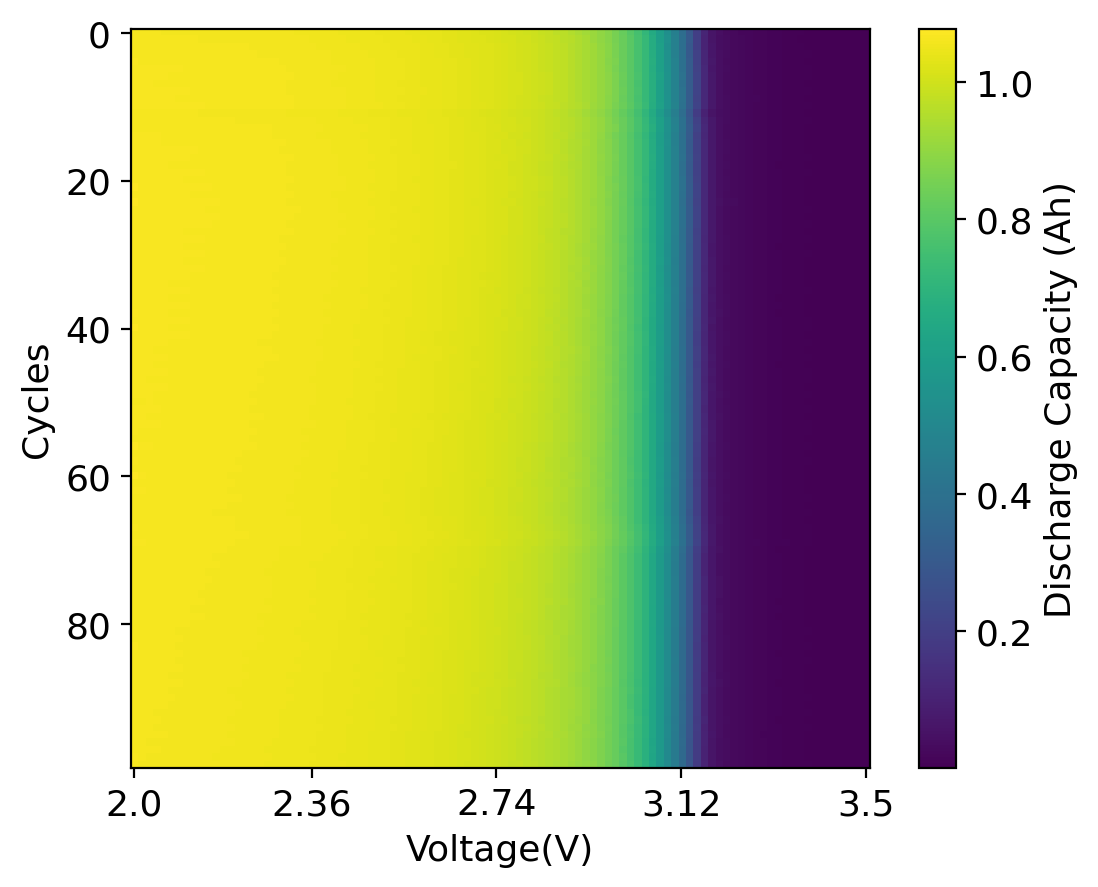

In [12]:
# plot a set of discharge curves used as an input
QV = pd.DataFrame(QV_curve_train[26,:,:]).squeeze()
label_ind = np.linspace(0,99,5).astype(int)

fig = plt.imshow(QV)
bar = plt.colorbar(fig,label='Discharge Capacity (Ah)')
plt.xlabel('Voltage(V)')
plt.ylabel('Cycles')
plt.xticks(label_ind)
plt.gca().set_xticklabels(np.round(voltages[label_ind],2))

/tmp/ipykernel_25770/1108158141.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(np.round(voltages[label_ind],2))


[Text(0, 0, '2.0'),
 Text(24, 0, '2.36'),
 Text(49, 0, '2.74'),
 Text(74, 0, '3.12'),
 Text(99, 0, '3.5')]

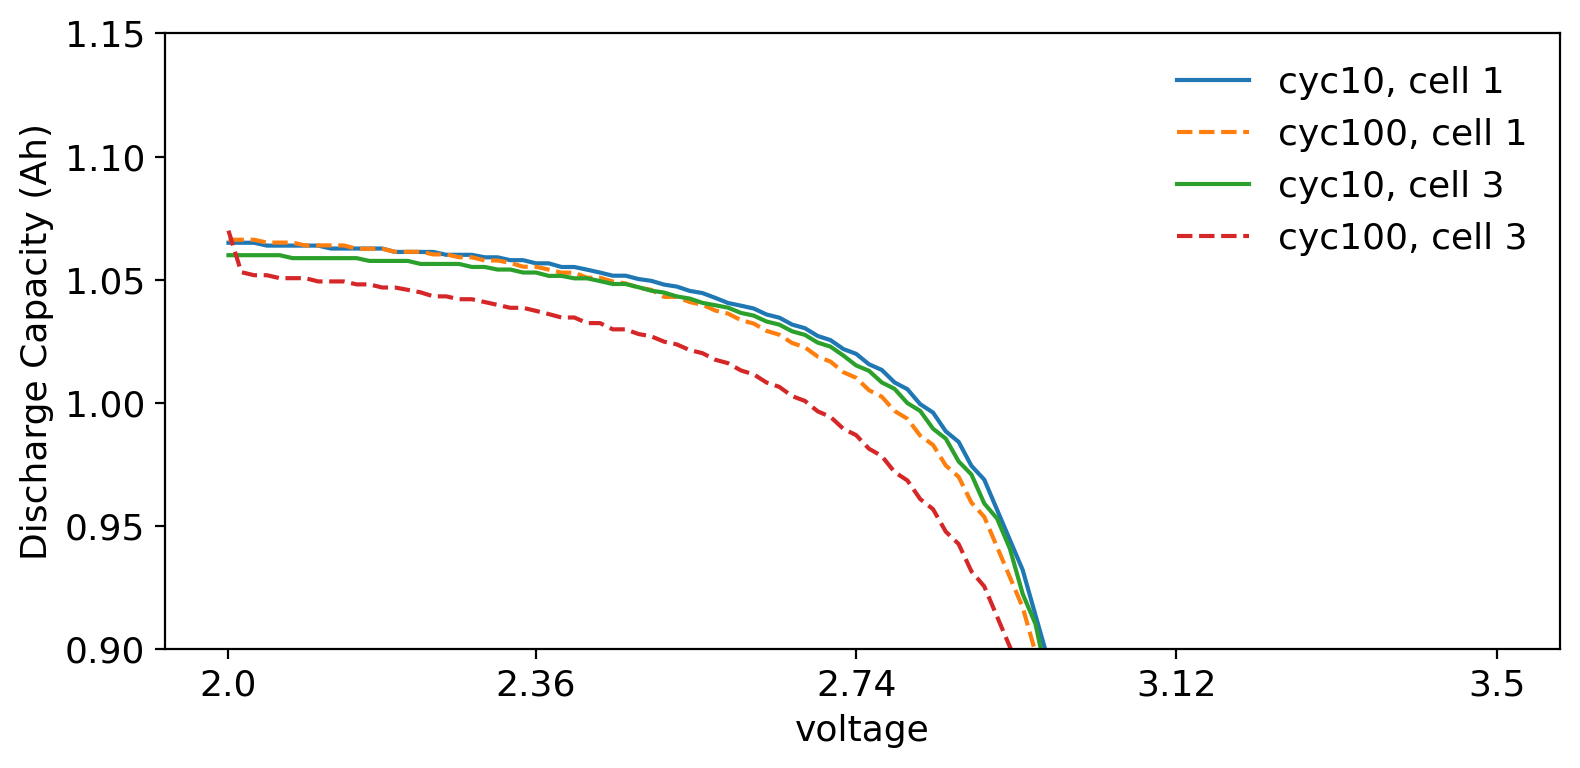

In [13]:
cell_nums = [1,3]
QV2 = QV.to_numpy()
fig,ax = plt.subplots(figsize=(9,4))
for cell_num in cell_nums:
    plt.plot(QV_curve_train[cell_num,10,:],label=('cyc10, cell '+str(cell_num))) #marker='o'    
    plt.plot(QV_curve_train[cell_num,99,:],'--',label=('cyc100, cell '+str(cell_num)))
    

ax.legend()
ax.set_ylim([0.9,1.15])
ax.set_ylabel('Discharge Capacity (Ah)')
ax.set_xlabel('voltage')
plt.gca().set_xticklabels(np.round(voltages[label_ind],2))
plt.xticks(label_ind)
plt.gca().set_xticklabels(np.round(voltages[label_ind],2))

In [14]:
#difference between 100th and 10th discharge curves
Qdiff_train = QV_curve_train[:,9,:]-QV_curve_train[:,99,:]
Qdiff_test = QV_curve_test[:,9,:]-QV_curve_test[:,99,:]

In [15]:
#apply moving average filter to smooth data
smooth = np.zeros(np.shape(Qdiff_train))
N = 15
for i in np.arange(0,np.shape(Qdiff_train)[0]-1):
    smooth[i,:] = np.convolve(Qdiff_train[i,:], np.ones((N,))/N, mode='same')
Qdiff_train = smooth 
    

smooth = np.zeros(np.shape(Qdiff_test))

for i in np.arange(0,np.shape(Qdiff_test)[0]-1):
    smooth[i,:] = np.convolve(Qdiff_test[i,:], np.ones((N,))/N, mode='same')
Qdiff_test = smooth

smooth = np.zeros(np.shape(full_dc_train))

for i in np.arange(0,np.shape(full_dc_train)[0]-1):
    smooth[i,:] = np.convolve(full_dc_train[i,:], np.ones((N,))/N, mode='same')
full_dc_train = smooth 
    

smooth = np.zeros(np.shape(full_dc_test))

for i in np.arange(0,np.shape(full_dc_test)[0]-1):
    smooth[i,:] = np.convolve(full_dc_test[i,:], np.ones((N,))/N, mode='same')
full_dc_test = smooth

In [16]:
# Option 2 for output
# one value of cycle life for each cell
CycLife_train = (full_dc_train >= .8).sum(axis=1)
CycLife_test = (full_dc_test >= .8).sum(axis=1)

/tmp/ipykernel_25770/3941007769.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(name='Greens')
/tmp/ipykernel_25770/3941007769.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(np.round(voltages[label_ind],2))


[Text(0, 0, '2.0'),
 Text(24, 0, '2.36'),
 Text(49, 0, '2.74'),
 Text(74, 0, '3.12'),
 Text(99, 0, '3.5')]

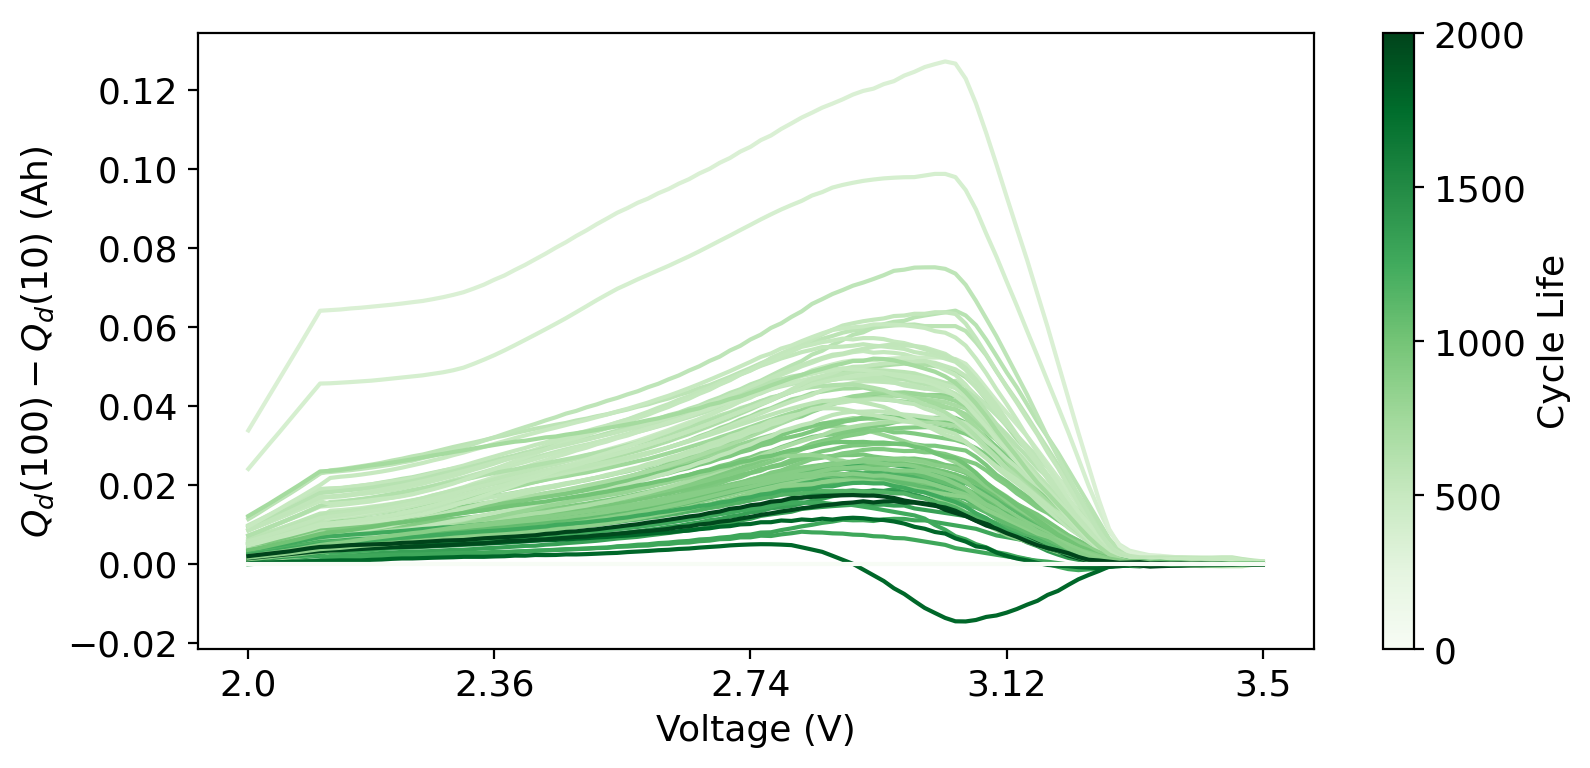

In [17]:
#plot capacity loss for first 90 cycles as a function of voltage
cmap = plt.cm.get_cmap(name='Greens')
col = cmap((CycLife_train/max(CycLife_train)))

cell_nums = np.arange(0,np.shape(Qdiff_train)[0])
fig,ax = plt.subplots(figsize=(9,4))
for cell_num in cell_nums:
    plt.plot(Qdiff_train[cell_num,:],label=('cell '+str(cell_num)),color=col[cell_num]) #marker='o'    
    
cbar = fig.colorbar(mappable=None,ax=ax, cmap=cmap,label='Cycle Life')
cbar.set_ticks(np.arange(0,1.25,.25))
cbar.set_ticklabels(np.arange(0,2000*1.25,2000/4).astype(int))
ax.set_ylabel('$Q_d(100) - Q_d(10)$ (Ah)')
ax.set_xlabel('Voltage (V)')
plt.gca().set_xticklabels(np.round(voltages[label_ind],2))
plt.xticks(label_ind)
plt.gca().set_xticklabels(np.round(voltages[label_ind],2))

In [18]:
# examine correlation of cycle life and first 100 cycle capacity loss
varQ_train= Qdiff_train.var(axis=1)
varQ_test= Qdiff_test.var(axis=1)
varQ = np.concatenate([varQ_train,varQ_test])
Cyc_tot = np.concatenate([CycLife_train,CycLife_test])
print(np.shape(varQ),np.shape(Cyc_tot))

(133,) (133,)


PearsonRResult(statistic=-0.28233510709224596, pvalue=0.0009927822801984473)


/tmp/ipykernel_25770/771512929.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(name='Greens')


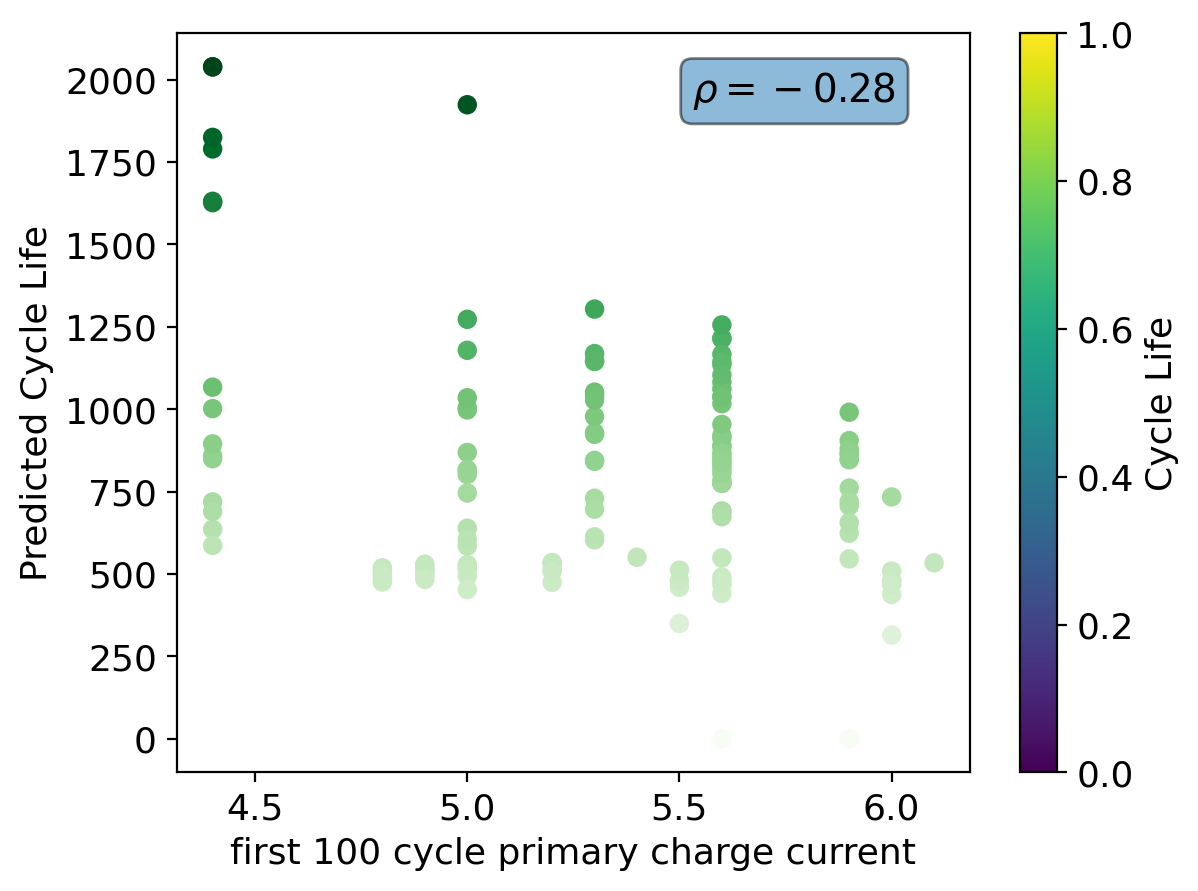

In [19]:
# examine correlation of cycle life and first 100 cycle primary charge current
I1 = np.concatenate([I1_train,I1_test])
cmap = plt.cm.get_cmap(name='Greens')
col = cmap((Cyc_tot/max(Cyc_tot)))

fig = plt.figure()
ax = fig.add_subplot()
sca = ax.scatter(I1,Cyc_tot,c=col)
#ax.set_xscale('log')

corr = scipy.stats.pearsonr(I1,Cyc_tot)
print(corr)


ax.set_ylabel('Predicted Cycle Life')
ax.set_xlabel('first 100 cycle primary charge current')

props = dict(boxstyle='round', alpha=0.5)

textstr = (r'$\rho = %.2f$' % (corr[0]))
                      
# place a text box in upper left in axes coords
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.colorbar(sca,label='Cycle Life')


PearsonRResult(statistic=0.09967580893222824, pvalue=0.25365688873237463)


/tmp/ipykernel_25770/3564909718.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(name='Greens')


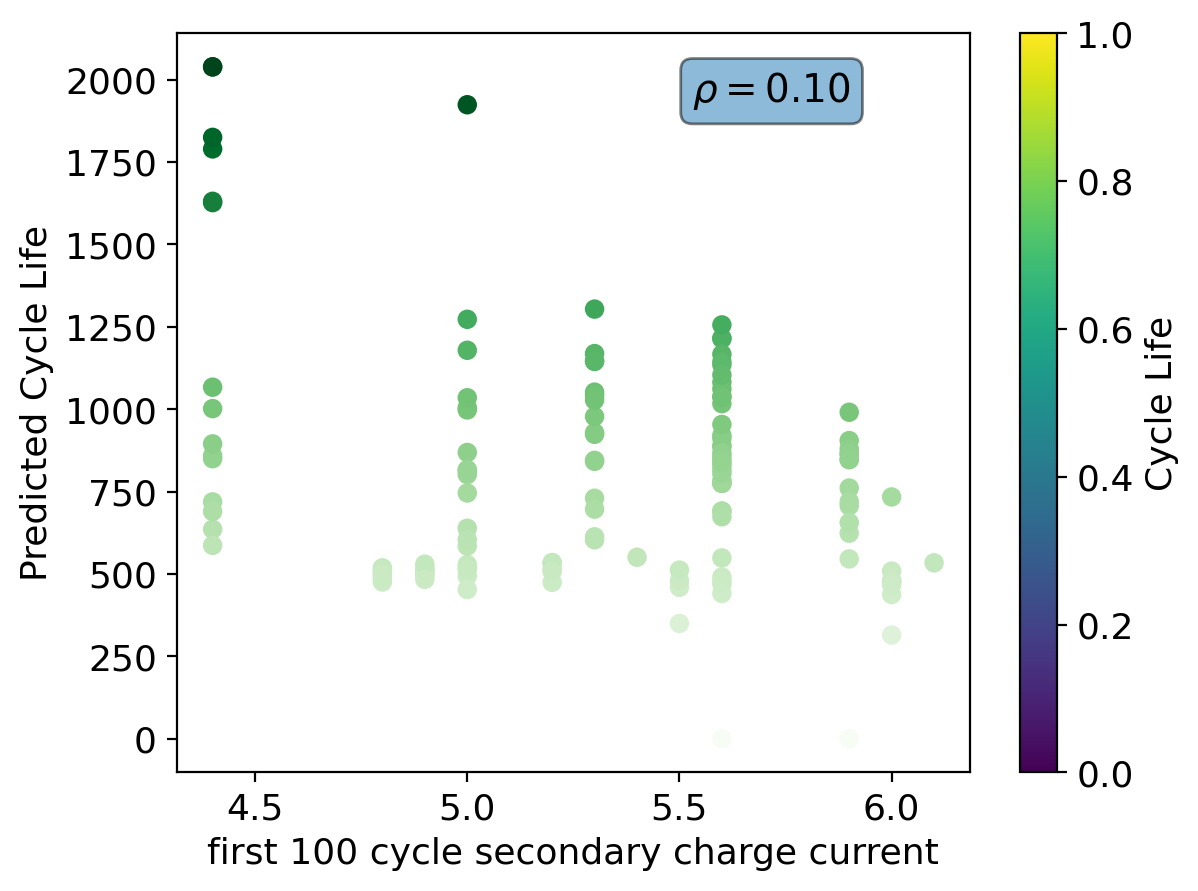

In [20]:
# examine correlation of cycle life and first 100 cycle secondary charge current
I2 = np.concatenate([I2_train,I2_test])
cmap = plt.cm.get_cmap(name='Greens')
col = cmap((Cyc_tot/max(Cyc_tot)))

fig = plt.figure()
ax = fig.add_subplot()
sca = ax.scatter(I1,Cyc_tot,c=col)
#ax.set_xscale('log')
ax.set_ylabel('Predicted Cycle Life')
ax.set_xlabel('first 100 cycle secondary charge current')

corr = scipy.stats.pearsonr(I2,Cyc_tot)
print(corr)

props = dict(boxstyle='round', alpha=0.5)

textstr = (r'$\rho = %.2f$' % (corr[0]))
                      
# place a text box in upper left in axes coords
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.colorbar(sca,label='Cycle Life')

PearsonRResult(statistic=-0.5385783456191384, pvalue=2.2820209931369904e-11)


/tmp/ipykernel_25770/3152882971.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(name='Greens')


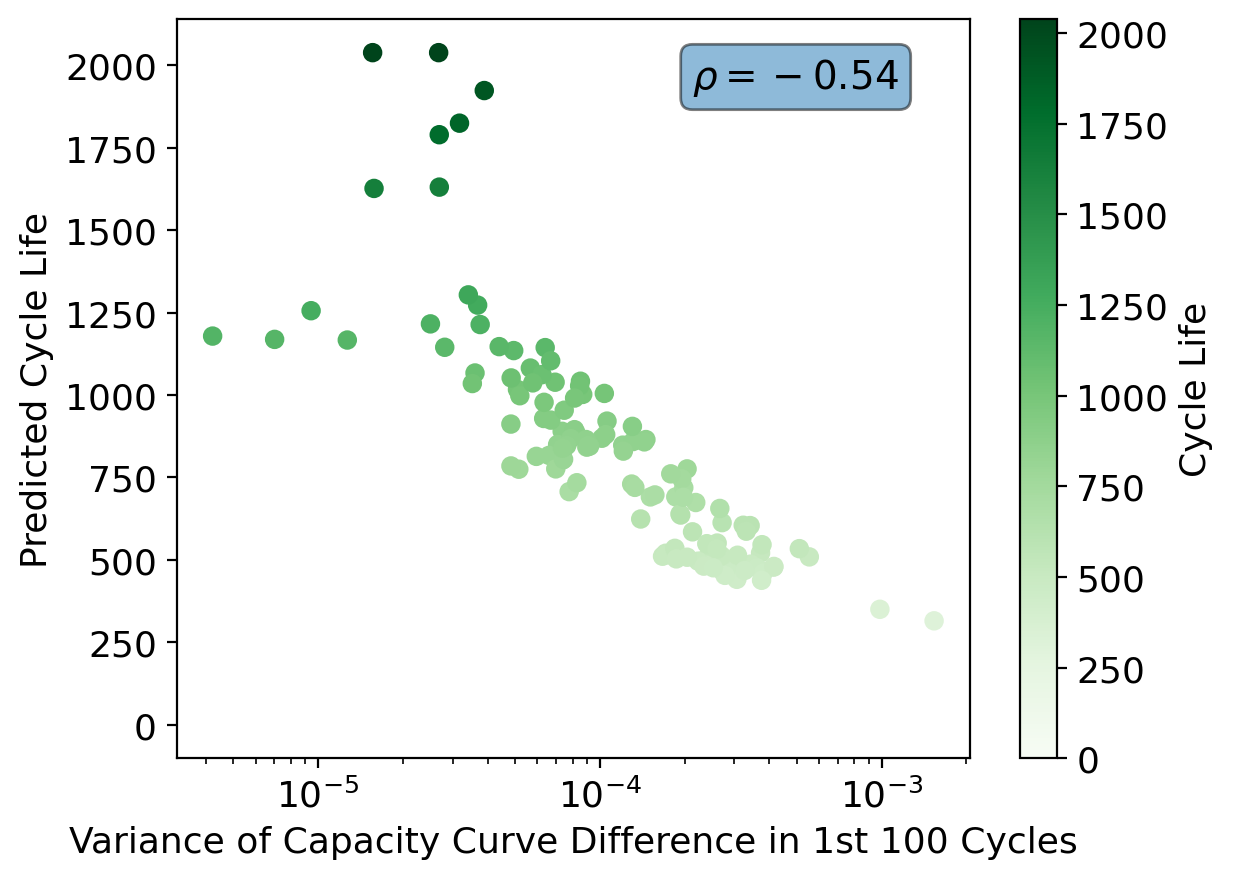

In [21]:
cmap = plt.cm.get_cmap(name='Greens')
col = cmap(Cyc_tot/max(Cyc_tot))

fig = plt.figure()
ax = fig.add_subplot()
sca = ax.scatter(varQ,Cyc_tot,c=Cyc_tot, vmin=0, vmax=max(Cyc_tot),cmap=cmap)
ax.set_xscale('log')

corr = scipy.stats.pearsonr(varQ,Cyc_tot)
print(corr)

ax.set_ylabel('Predicted Cycle Life')
ax.set_xlabel('Variance of Capacity Curve Difference in 1st 100 Cycles')

props = dict(boxstyle='round', alpha=0.5)

textstr = (r'$\rho = %.2f$' % (corr[0]))
                      
# place a text box in upper left in axes coords
ax.text(0.65, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.colorbar(sca,label='Cycle Life')


<Axes: >

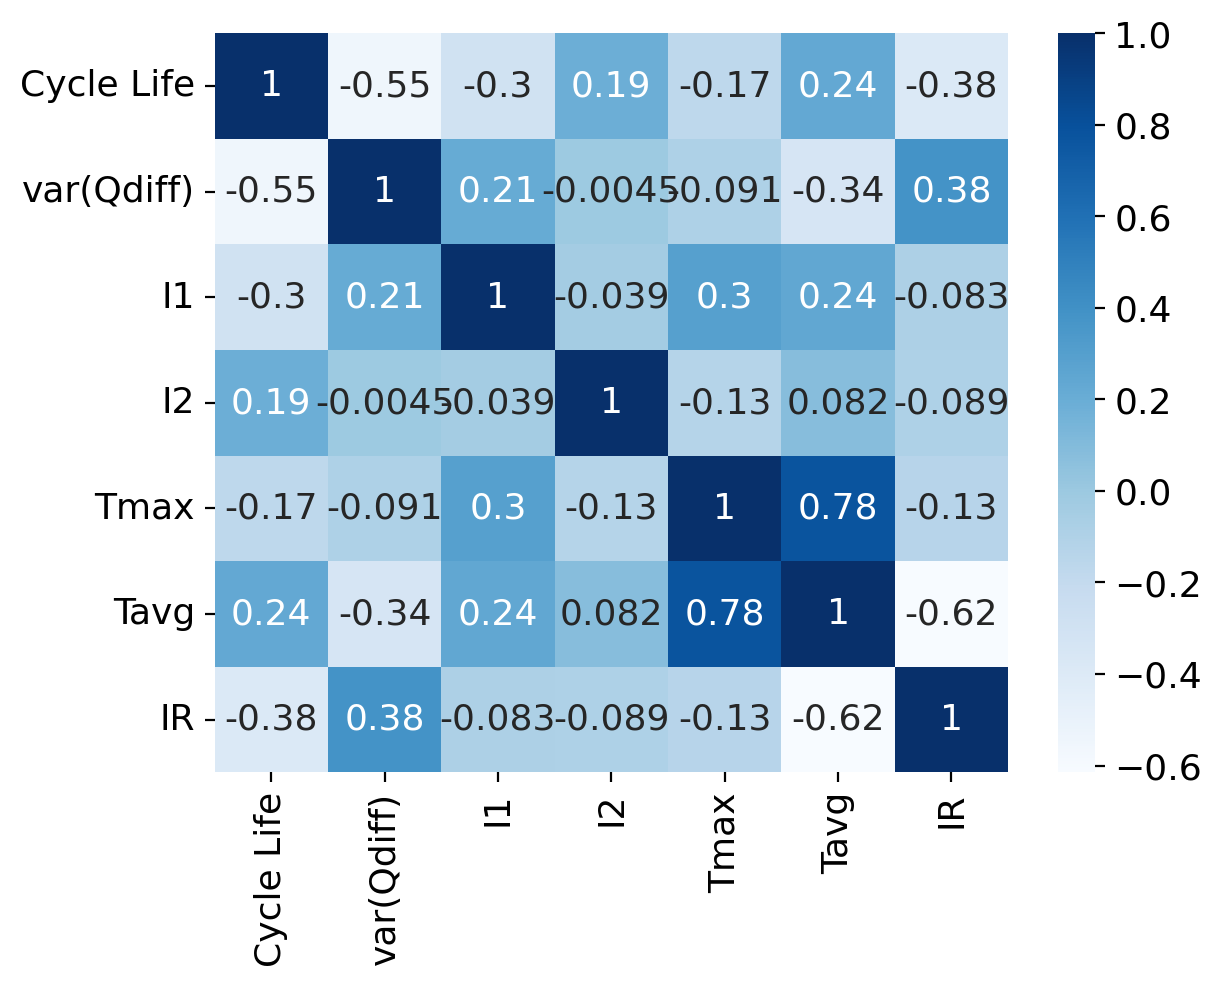

In [22]:
keys = ['Cycle Life', 'var(Qdiff)', 'I1', 'I2', 'Tmax', 'Tavg', 'IR']
df = pd.DataFrame(np.vstack([CycLife_train,varQ_train,I1_train,I2_train
                             ,Tmax_train,TAv_train,IR_train]),index=keys)
CorrMat = df.swapaxes(axis1=0,axis2=1).corr()
sb.heatmap(CorrMat, cmap="Blues", annot=True)


## Options for X:
QV_curve_train and QV_curve_test
Discharge Capacity vs Voltage for first 100 cycles
size: cells x (100 x 100)

Qdiff_train and Qdiff_test
Difference in Discharge Capacity vs Voltage curves between 10th and 100th cycles
size: cells x 100

varQ_train and varQ_test
Variance of Qdiff
size: cells x 1

I1, I2, I3
Currents used for constant current charging steps. (I3 is probably useless)
size: cells x 1

TAv, Tmax, IR
Average temperature, max temperature, and max internal resistance values for 1st 100 cycles
size: cells x 1

In [23]:
print('QV_curve- test/train'+str(np.shape(QV_curve_train))+'/'+str(np.shape(QV_curve_test)))
print('Qdiff- test/train'+str(np.shape(Qdiff_train))+'/'+str(np.shape(Qdiff_test)))
print('varQ- test/train'+str(np.shape(varQ_train))+'/'+str(np.shape(varQ_test)))
print('I1- test/train'+str(np.shape(I1_train))+'/'+str(np.shape(I1_test)))

QV_curve- test/train(79, 100, 100)/(54, 100, 100)
Qdiff- test/train(79, 100)/(54, 100)
varQ- test/train(79,)/(54,)
I1- test/train(79,)/(54,)


## Options for Y:
full_dc_train and full_dc_test
Discharge capacity curve for 2048 discharge cycles
size: cells x 2048

CycLife_train and CycLife_test
Number of cycles before battery degrades past usability
size: cells x 1

Param (not included here yet)
Parameterized curve for capacity fade
size: cells x 4

In [24]:
print('full_dc- test/train'+str(np.shape(full_dc_train))+'/'+str(np.shape(full_dc_test)))
print('CycLife- test/train'+str(np.shape(CycLife_train))+'/'+str(np.shape(CycLife_test)))

full_dc- test/train(79, 2048)/(54, 2048)
CycLife- test/train(79,)/(54,)


In [41]:
X_train = np.vstack([varQ_train,I1_train,TAv_train,IR_train]).transpose()
X_test = np.vstack([varQ_test,I1_test,TAv_test,IR_test]).transpose()

Y_train = CycLife_train
Y_test = CycLife_test

In [42]:
# Normalize predictors
mean, std = X_train.mean(), X_train.std()
X_train   = (X_train - mean)/std
X_test    = (X_test - mean)/std

In [43]:
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

(79, 4) (79,) (54, 4) (54,)


## Build the Model

In [44]:
minibatch_size = 1
num_epochs     = 300
n_trials       = 10   # total number of trials in hyperparameter tuning

In [45]:
def build_model(hp):
    
    # options for hyperparameters
    hp_n_layers = hp.Choice('N_layers', values=[2,3,4,5,6])
    hp_n_neurons = hp.Choice('n_neurons', values=[16,32,64,128,256])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    
    # build CNN models according to the hyperparameters
    
    model = keras.models.Sequential()

    model.add(Dense(hp_n_neurons,  activation=hp_activation, name="hidden_layer_1" ,input_shape=(X_train.shape[1],)))
    
    for n in range(hp_n_layers-1):
        model.add(Dense(hp_n_neurons,  activation=hp_activation, name="hidden_layer_"+str(n+2))) 
    
    # model.add(Dense(1, activation='sigmoid', name="output_layer")) # shape: (2048,1)    
    model.add(Dense(1, activation='linear', name="output_layer2")) # shape: (2048,1)

    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))

    return model

In [51]:
# Instantiate the Tuner and save the trials in a directory with customized project name
random_tuner = keras_tuner.RandomSearch(build_model, 
                                        max_trials=n_trials,
                                        seed=9,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=5,
                                        directory='random_search', 
                                        project_name='random_search_Short_NN_varQ6')

In [52]:
random_tuner.search_space_summary()

Search space summary
Default search space size: 5
N_layers (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5, 6], 'ordered': True}
n_neurons (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'mae'], 'ordered': False}


In [53]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [54]:
# Perform hypertuning
random_tuner.search(X_train, Y_train,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])


Trial 10 Complete [00h 00m 31s]
val_loss: 394.8677978515625

Best val_loss So Far: 314.0696716308594
Total elapsed time: 00h 05m 13s


In [50]:
# display the model structure with the best tuning
best_model = random_tuner.get_best_models()[0]
best_model.summary()

ValueError: Received incompatible tensor with shape (100, 64) when attempting to restore variable with shape (4, 64) and name hidden_layer_1/kernel:0.

In [ ]:
# check hyperparameters of the all tuning trials
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

In [ ]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(X_train, Y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(X_train, Y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


In [ ]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
# plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title('NN: Single value inputs/ single output', fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# # ---------- ranking #2 tuning ----------
# plt.subplot(1, 2, 2)
# plt.plot(history_top2.history['loss'])
# plt.plot(history_top2.history['val_loss'])
# plt.title(title_top2, fontsize=12)
# plt.ylabel(ylabel_top2)
# plt.xlabel('Epoch')
# plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')


In [ ]:
model_path = os.path.join(bwd,'saved_model')
#make_dir(model_path)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_best.save(os.path.join(model_path,'NN_Short_model_randomsearch_varQ5_rank1.h5'))
model_top2.save(os.path.join(model_path,'NN_Short_model_randomsearch_varQ5_rank2.h5'))

### 4. Evaluate the trained model

In [ ]:
## reload the saved model
# ---------- best tuning ----------
model_best = load_model(os.path.join(model_path,'NN_Short_model_randomsearch_varQ5_rank1.h5'))
# ---------- rank #2 tuning ----------
model_top2 = load_model(os.path.join(model_path,'NN_Short_model_randomsearch_varQ5_rank2.h5'))

In [ ]:
## generate the prediction from the model
# ---------- best tuning ----------
y_test_best_pre = model_best.predict(X_test)
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(X_test)

plot data from a chosen cell and compare with the model prediction

In [ ]:
# evaluate the predictions
mae2 = mean_absolute_error(CycLife_test, y_test_best_pre)
print(f"Mean Absolute Error: {mae2}")

rmse2 = mean_squared_error(CycLife_test, y_test_best_pre, squared=False)
print(f"Root Mean Squared Error: {rmse2}")

In [ ]:
fig,ax = plt.subplots(figsize=(8,6))
plt.scatter(CycLife_test,y_test_best_pre)
plt.plot(range(0,max(CycLife_test)),range(0,max(CycLife_test)))
ax.set_ylabel('Predicted Cycle Life')
ax.set_xlabel('True Cycle Life')

props = dict(boxstyle='round', alpha=0.5)

textstr = '\n'.join((
                      r'Root Mean Squared Error: %.1f' % (rmse2),
                      r'Mean Absolute Error: %.1f' % (mae2)))
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('NN: Single value inputs/output')